<a href="https://colab.research.google.com/github/Vinaypatil-Ev/vinEvPy-GoCoLab/blob/main/Tensorflow/TensorflowPrac23_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

In [5]:
layer1 = tf.keras.layers.Dense(2)
layer2 = tf.keras.layers.Dense(2)

In [6]:
inputs = tf.keras.Input((2))
outputs = layer2(layer1(inputs))
model = tf.keras.Model(inputs, outputs)

In [7]:
layer1.get_weights()

[array([[0.29286623, 0.6924528 ],
        [0.05890989, 0.37736285]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [8]:
layer2.get_weights()

[array([[ 1.1728019 , -0.27321512],
        [-0.7195486 ,  0.6063131 ]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [9]:
layer1.trainable = False

In [10]:
model.compile("adam", "mse")
model.fit(tf.random.normal([3, 2]), tf.random.normal([3, 2]), epochs=10)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.9658
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9647
Epoch 3/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9635
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9624
Epoch 5/10
1/1 [==============================] - 0s 3ms/step - loss: 0.9612
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 0.9601
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9589
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 0.9578
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9566
Epoch 10/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9555


In [11]:
layer1.get_weights()

[array([[0.29286623, 0.6924528 ],
        [0.05890989, 0.37736285]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [12]:
layer2.get_weights()

[array([[ 1.1628071 , -0.26320297],
        [-0.7295342 ,  0.5963182 ]], dtype=float32),
 array([-0.00999305, -0.00998578], dtype=float32)]

## transfer learning

In [13]:
base_model = tf.keras.applications.VGG16(
    False,
    "imagenet",
    input_shape=(150, 150, 3)
)

58892288/58889256 [==============================] - 0s 0us/step


In [14]:
# tf.keras.utils.plot_model(base_model, show_shapes=True)

In [15]:
# base_model = tf.keras.applications.VGG16(
#     True,
#     "imagenet",
# )

In [16]:
# tf.keras.utils.plot_model(base_model, show_shapes=True)

In [17]:
tfds.disable_progress_bar()

In [18]:
trn_ds, val_ds, tst_ds, remain = tfds.load(
    "cats_vs_dogs",
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]", "train[60%:100%]"],
    as_supervised=True
)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete4DO6CR/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


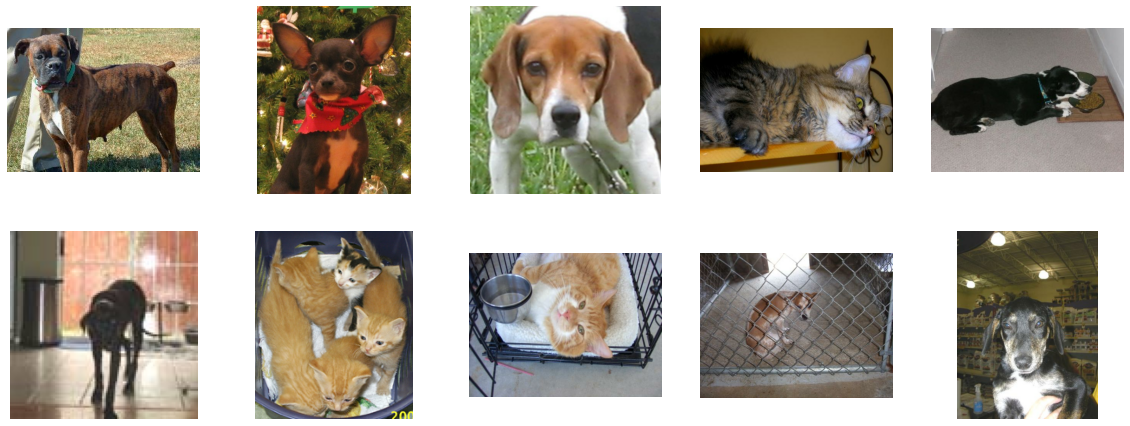

In [19]:
plt.figure(figsize=(20, 20))
for i , (img, label) in enumerate(trn_ds.take(10)):
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.axis("off")

#process data

In [20]:
size = (150, 150)
trn_ds = trn_ds.map(lambda x, y: (tf.image.resize(x, size), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, size), y))
tst_ds = tst_ds.map(lambda x, y: (tf.image.resize(x, size), y))
remain = remain.map(lambda x, y: (tf.image.resize(x, size), y))

In [21]:
batch_size = 32
trn_ds = trn_ds.cache().batch(batch_size).prefetch(buffer_size=10)
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=10)
tst_ds = tst_ds.cache().batch(batch_size).prefetch(buffer_size=10)
remain = remain.cache().batch(batch_size).prefetch(buffer_size=10)

In [22]:
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomRotation((-1, 0.7)),
])

In [23]:
i = 0

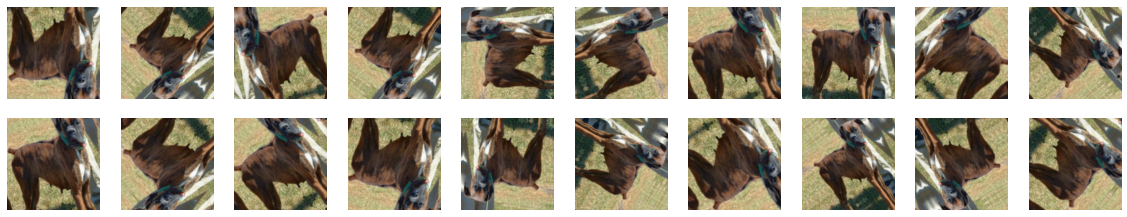

In [24]:
for img, label in trn_ds.take(1):
    plt.figure(figsize=(20, 20))
    img = img[0] / 255.0
    for i in range(20):
        plt.subplot(10, 10, i+1)
        aug_img = data_augmentation(tf.expand_dims(img, 0), training=True)
        plt.imshow(tf.squeeze(aug_img))
        plt.axis("off")
        i += 1

In [25]:
inputs = tf.keras.Input((150, 150, 3))
x = data_augmentation(inputs)
norm_layer = tf.keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
x = norm_layer(x)
norm_layer.set_weights([mean, var])
x = base_model(x, training=False)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(64, activation="relu")(x)
outputs = tf.keras.layers.Dense(1)(x)

In [26]:
with tf.device("GPU:0"):
    model = tf.keras.Model(inputs, outputs)

In [27]:
base_model.trainable = False

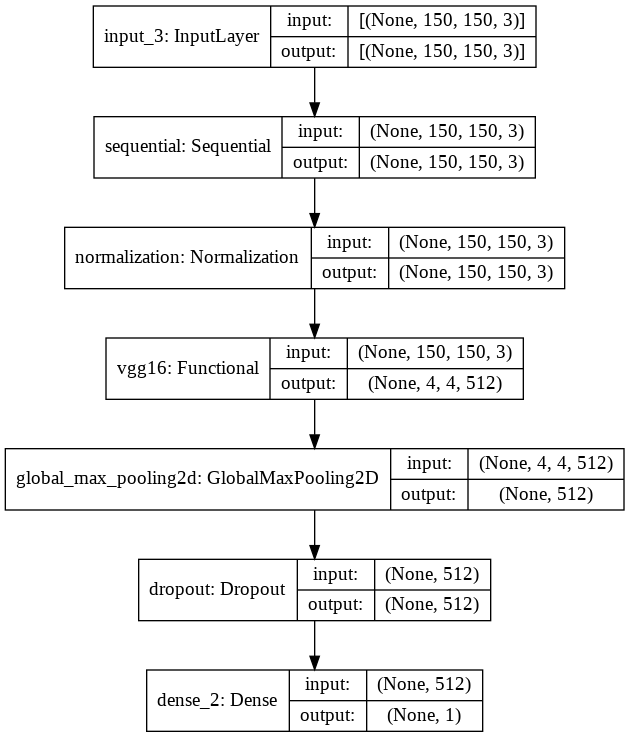

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [29]:
model.compile("adam",
              loss=tf.keras.losses.BinaryCrossentropy(True),
              metrics=[tf.keras.metrics.BinaryAccuracy()]
              )

In [30]:
model.fit(trn_ds, epochs=25, validation_data=val_ds)

Epoch 1/25
291/291 [==============================] - 33s 90ms/step - loss: 0.6426 - binary_accuracy: 0.6296 - val_loss: 0.2955 - val_binary_accuracy: 0.8779
Epoch 2/25
291/291 [==============================] - 24s 84ms/step - loss: 0.4819 - binary_accuracy: 0.7459 - val_loss: 0.2567 - val_binary_accuracy: 0.8908
Epoch 3/25
291/291 [==============================] - 25s 86ms/step - loss: 0.4582 - binary_accuracy: 0.7707 - val_loss: 0.2486 - val_binary_accuracy: 0.9046
Epoch 4/25
291/291 [==============================] - 26s 88ms/step - loss: 0.4436 - binary_accuracy: 0.7769 - val_loss: 0.2339 - val_binary_accuracy: 0.9054
Epoch 5/25
291/291 [==============================] - 25s 87ms/step - loss: 0.4279 - binary_accuracy: 0.7846 - val_loss: 0.2275 - val_binary_accuracy: 0.9089
Epoch 6/25
291/291 [==============================] - 25s 86ms/step - loss: 0.4351 - binary_accuracy: 0.7871 - val_loss: 0.2335 - val_binary_accuracy: 0.9097
Epoch 7/25
291/291 [==============================] 

In [31]:
model.distribute_strategy

In [32]:
model.run_eagerly

False

In [33]:
base_model.trainable

False

In [34]:
model.trainable

True

In [35]:
# model.trainable=True
base_model.trainable = True

In [36]:
model.compile(tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(True),
              metrics=[tf.keras.metrics.BinaryAccuracy()]
              )

In [37]:
model.fit(remain, epochs=10, validation_data=val_ds)

Epoch 1/10
291/291 [==============================] - 73s 241ms/step - loss: 0.3669 - binary_accuracy: 0.8268 - val_loss: 0.1905 - val_binary_accuracy: 0.9347
Epoch 2/10
291/291 [==============================] - 68s 235ms/step - loss: 0.2463 - binary_accuracy: 0.8870 - val_loss: 0.1630 - val_binary_accuracy: 0.9445
Epoch 3/10
291/291 [==============================] - 68s 234ms/step - loss: 0.2027 - binary_accuracy: 0.9114 - val_loss: 0.1197 - val_binary_accuracy: 0.9587
Epoch 4/10
291/291 [==============================] - 68s 234ms/step - loss: 0.1663 - binary_accuracy: 0.9328 - val_loss: 0.1542 - val_binary_accuracy: 0.9484
Epoch 5/10
291/291 [==============================] - 68s 234ms/step - loss: 0.1611 - binary_accuracy: 0.9313 - val_loss: 0.1237 - val_binary_accuracy: 0.9544
Epoch 6/10
291/291 [==============================] - 68s 234ms/step - loss: 0.1399 - binary_accuracy: 0.9438 - val_loss: 0.1651 - val_binary_accuracy: 0.9454
Epoch 7/10
291/291 [==========================

In [38]:
model.trainable

True

In [39]:
base_model

In [46]:
img = trn_ds.take(1)

In [53]:
next(img.as_numpy_iterator())[0][:1].shape

(1, 150, 150, 3)

In [56]:
model.save("/content/drive/MyDrive/models/vgg/1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/vgg/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/vgg/1/assets
